### Libraries

In [269]:
import pandas as pd
import numpy as np
import numbers
import matplotlib.pyplot as plt
from dataclasses import dataclass
from enum import Enum
# import seaborn as sns # improves plot aesthetics

### Data

In [330]:
# plot_axes = {
#     "Words Per Minute (WPM)": [0, 80],
#     "Total Error Rate": [0,1],
#     "Flight Time": [0,100],
#     "Hold Time": [0,100],
#     "Suggestions": [0,100],
#     "Autocorrect": ['no','maybe','yes'],
# }

# # the number of columns should match the number of axes
# # order is determined by the defined axes

# plot_data = {
#     'ExpT': [38, .2, 0, 40, 22, 'yes'],
#     'ExpC': [1, .8, 22, 76, 100, 'no'],
#     'PasS': [80, .99, 1, 90, 90, 'maybe'],
#     'Transcriptions': [50, .5, 100, 34, 55, 'yes'],
# }

# n_ordinate_levels = 4

# print(plot_data)


plot_axes = {
    "Words Per Minute (WPM)": [0, 1],
    "Total Error Rate": [0,1],
    "Flight Time": [0,1],
    "Hold Time": [0,1],
    "Suggestions": [0,1],
    "Autocorrect": ['no','maybe','yes','come_again?'],
}

# the number of columns should match the number of axes
# order is determined by the defined axes

plot_data = {
    'ExpT': [.1, .1, .1, .1, .1, 'yes'],
    'ExpC': [.33, .33, .33, .33, .33, 'no'],
    'PasS': [.67, .67, .67, .67, .67, 'maybe'],
    'Transcriptions': [1, 1, 1, 1, 1, 'yes'],
}

n_ordinate_levels = 4


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.25], [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.5], [1.0, 1.0, 1.0, 1.0, 1.0, 0.75], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]


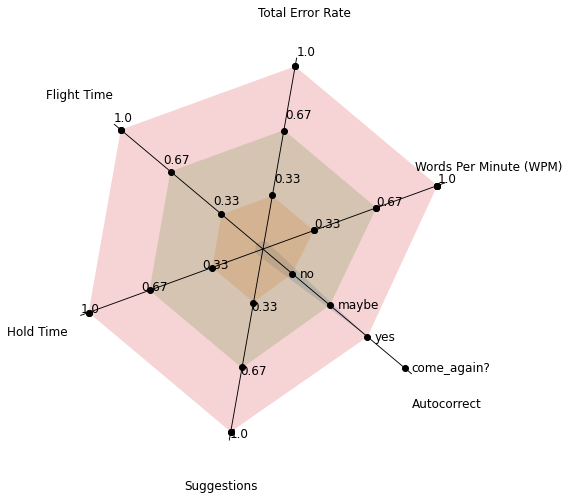

In [331]:
def gen_axes_labels(axes, n_ordinate_levels):

    # check data type by provided ranges for each axis    
    # if a string is in its range or it has other than 2 values, the axes is categorical, else continuous
    result = {}
    for name, ranges in plot_axes.items():
        if any(map(lambda x: not isinstance(x, numbers.Number), ranges)) or len(ranges) != 2:
            result[name] = {
                'type': 'cat',
                'grid': np.linspace(0,1,num=len(ranges)+1),
                'labels': [''] + ranges,
                'minmax': [] 
            }
        else:
            labels= [f'{round(x,2)}' for x in np.linspace(*ranges, num=n_ordinate_levels)]
            result[name] = {
                'type': 'cont',
                'grid': np.linspace(*ranges,num=n_ordinate_levels),
                'labels': [''] + labels[1:],
                'minmax': ranges
            }
    return result
    
    
def norm_data(unnorm_data, axes_labels):
    
    norm_data = []
    axes_labels_list = list(axes_labels.values())
    
    for index, val in enumerate(unnorm_data):

        this_range = axes_labels_list[index]['labels']
        # if categorical
        if axes_labels_list[index]['type'] == 'cat':

            # must be existing value
            if val not in this_range:
                raise ValueError(f"{val} is not in {this_range}")

            normalised = this_range.index(val)/(len(this_range)-1)
            norm_data.append(normalised)

        # if continuous
        else:
            mini, maxi = axes_labels_list[index]['minmax']
            
            # must be within range
            if (val <= mini and val >= maxi):
                raise ValueError(f"{val} is not between {mini} and {maxi}")

            normalised = (val-mini)/(maxi-mini)
            norm_data.append(normalised)

    return norm_data

def set_rgrids(self, radii, labels=None, angle=None, fmt=None,
               **kwargs):

    # Make sure we take into account unitized data
    radii = self.convert_xunits(radii)
    radii = np.asarray(radii)
    rmin = radii.min()
    # if rmin <= 0:
    #     raise ValueError('radial grids must be strictly positive')

    self.set_yticks(radii)
    if labels is not None:
        self.set_yticklabels(labels)
    elif fmt is not None:
        self.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    if angle is None:
        angle = self.get_rlabel_position()
    self.set_rlabel_position(angle)
    for t in self.yaxis.get_ticklabels():
        t.update(kwargs)
    return self.yaxis.get_gridlines(), self.yaxis.get_ticklabels()


class ComplexRadar():
    def __init__(self, fig, axes, n_ordinate_levels = 4):
        
        # create all polar axes
        polar_axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True) for i in range(len(axes))]
        
        # create evenly spaced angles for the number of variables
        angles = np.arange(20, 370, 360./len(axes))
            
        # create lines (not used) and lables for each axis
        _, text = polar_axes[0].set_thetagrids(angles, labels=axes.keys())
        
        # rotate the axes text according to the axes angle
        text = [t.set_rotation(a-90) for t, a in zip(text, angles)]
        
        # tweak axes labels
        for ax in polar_axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        
        # generate the tick lables for each axes
        self.tick_labels = gen_axes_labels(axes, n_ordinate_levels)
        
        # set grids for each axis
        for i, (k, v) in enumerate(self.tick_labels.items()):
            set_rgrids(polar_axes[i], v['grid'], labels=v['labels'], angle=angles[i])
            polar_axes[i].spines["polar"].set_visible(False)

            polar_axes[i].grid(color='black', linewidth=.9)
            polar_axes[i].grid(False, axis='y')
            polar_axes[i].tick_params(pad=35,labelsize='large')

            # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ax = polar_axes[0]
        
        # generate dots for visual effect
        points_per_line = [x['grid'] for x in self.tick_labels.values()]
        max_points = max([len(x) for x in points_per_line])
        points = [np.r_[p, np.full(max_points - len(p), p[len(p)-1])] for p in points_per_line]
        point_scores = []
        for i in range(max_points):
            new_score = [p[i] for p in points]
            point_scores.append(new_score)
        
        print(point_scores)
        for point_list in point_scores[1:]:
            self.ax.plot(self.angle, np.r_[point_list, point_list[0]], color='black', marker='o', linestyle = 'None')
        
    def plot(self, plot_data, *args, **kw):
        data = norm_data(plot_data,self.tick_labels)
        self.ax.plot(self.angle, np.r_[data, data[0]], *args, **kw)
        
    def fill(self, plot_data, *args, **kw):
        data = norm_data(plot_data,self.tick_labels)
        self.ax.fill(self.angle, np.r_[data, data[0]], *args, **kw)
        

# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, plot_axes)
radar.fill(plot_data['ExpT'], alpha=0.2)
radar.fill(plot_data['ExpC'], alpha=0.2)
radar.fill(plot_data['PasS'], alpha=0.2)
radar.fill(plot_data['Transcriptions'], alpha=0.2)


plt.show()

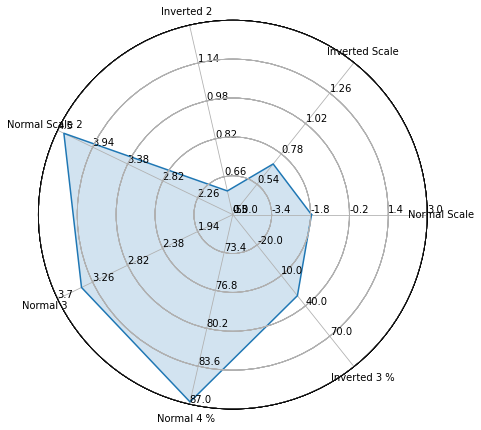

In [267]:
# OG CODE:

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    # for d, (y1, y2) in zip(data[1:], ranges[1:]):
    for d, (y1, y2) in zip(data, ranges):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)

    x1, x2 = ranges[0]
    d = data[0]

    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1

    sdata = [d]

    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1

        sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)

    return sdata

def set_rgrids(self, radii, labels=None, angle=None, fmt=None,
               **kwargs):
    """
    Set the radial locations and labels of the *r* grids.
    The labels will appear at radial distances *radii* at the
    given *angle* in degrees.
    *labels*, if not None, is a ``len(radii)`` list of strings of the
    labels to use at each radius.
    If *labels* is None, the built-in formatter will be used.
    Return value is a list of tuples (*line*, *label*), where
    *line* is :class:`~matplotlib.lines.Line2D` instances and the
    *label* is :class:`~matplotlib.text.Text` instances.
    kwargs are optional text properties for the labels:
    %(Text)s
    ACCEPTS: sequence of floats
    """
    # Make sure we take into account unitized data
    radii = self.convert_xunits(radii)
    radii = np.asarray(radii)
    rmin = radii.min()
    # if rmin <= 0:
    #     raise ValueError('radial grids must be strictly positive')

    self.set_yticks(radii)
    if labels is not None:
        self.set_yticklabels(labels)
    elif fmt is not None:
        self.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    if angle is None:
        angle = self.get_rlabel_position()
    self.set_rlabel_position(angle)
    for t in self.yaxis.get_ticklabels():
        t.update(kwargs)
    return self.yaxis.get_gridlines(), self.yaxis.get_ticklabels()

class ComplexRadar():
    def __init__(
        self, fig, variables, ranges, n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            # ax.set_rgrids(grid, labels=gridlabel, angle=angles[i])
            set_rgrids(ax, grid, labels=gridlabel, angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


# example data
variables = ("Normal Scale", "Inverted Scale", "Inverted 2", 
            "Normal Scale 2", "Normal 3", "Normal 4 %", "Inverted 3 %")
data = (-1.76, 1.1, 1.2, 
        4.4, 3.4, 86.8, 20)
ranges = [(-5, 3), (1.5, 0.3), (1.3, 0.5),
         (1.7, 4.5), (1.5, 3.7), (70, 87), (100, -50)]            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()
